# Tugas 6 **Summary Dokumen**

Nama : Zainal Arifin

NIM  : 220411100103


#**Install Library**


In [ ]:
!pip install selenium
!pip install networkx
!pip install matplotlib
!pip install nltk
!pip install tqdm
!pip install pandas
!pip install sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import re

from tqdm import tqdm

import pickle
import nltk
import networkx as nx
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize , word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Crawling Data Artikel Berita
melakukan crawling untuk mengambil judul, isi, tanggal, dan kategori artikel dari URL yang diberikan, dan menyajikan data tersebut dalam bentuk DataFrame untuk kemudahan analisis lebih lanjut.

In [ ]:
def web_driver():
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

def get_element_text(driver, xpath):
    try:
        return WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, xpath))
        ).text.strip()
    except Exception as e:
        print(f"Error finding element with XPath {xpath}: {e}")
        return ""

def extract_article_content(driver, article_url):
    driver.get(article_url)
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//h1'))
    )
    title = get_element_text(driver, './/h1')

    # XPath untuk tanggal
    date = get_element_text(driver, './/p[@class="pt-20 date"]')

    # XPath untuk konten
    content_elements = driver.find_elements(By.XPATH, './/div[@class="news-text"]/p')
    content = " ".join(p.text for p in content_elements)

    # XPath untuk kategori
    kategori = get_element_text(driver, './/div[@class="breadcrumb-content"]/p')

    return {
        "Title": title,
        "Date": date,
        "Content": content,
        "Category": kategori  # Menyimpan kategori dalam hasil
    }

driver = web_driver()

# Meminta input dari pengguna untuk URL artikel
url_input = input("Masukkan URL artikel: ")

# Scraping data dari URL artikel yang diberikan oleh pengguna
article_data = extract_article_content(driver, url_input)

driver.quit()

# Simpan hasil scraping ke dalam DataFrame
data = pd.DataFrame([article_data])  # Mengonversi hasil ke dalam list untuk membuat DataFrame

Masukkan URL artikel: https://www.metrotvnews.com/play/NgxCVAPo-pengamat-heran-dengan-line-up-timnas-indonesia-lawan-tiongkok


#PREPROCESSING

In [ ]:
# Fungsi untuk mengubah teks menjadi huruf kecil
def clean_lower(text):
    if isinstance(text, str):
        return text.lower()
    return text

data['lower case'] = data['Content'].apply(clean_lower)

# Fungsi untuk membersihkan tanda baca dan angka (menghapus koma)
def clean_punct(text):
    if isinstance(text, str):
        clean_patterns = re.compile(r'[0-9]|[/(){}\[\]\|@,;_]|[^a-z .]+')  # Koma dihilangkan dari pengecualian
        text = clean_patterns.sub(' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

data['tanda baca'] = data['lower case'].apply(clean_punct)

# Fungsi untuk normalisasi spasi
def _normalize_whitespace(text):
    if isinstance(text, str):
        corrected = re.sub(r'\s+', ' ', text)
        return corrected.strip()
    return text

data['spasi'] = data['tanda baca'].apply(_normalize_whitespace)

# Tokenisasi
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    return text

data['token'] = data['spasi'].apply(tokenize_text)

# Pembersihan stopwords setelah tokenisasi
def clean_stopwords(tokens):
    if isinstance(tokens, list):
        stopword = set(stopwords.words('indonesian'))
        filtered_tokens = [word for word in tokens if word not in stopword]
        return filtered_tokens
    return tokens

data['stopwords'] = data['token'].apply(clean_stopwords)

# Gabungkan kembali token menjadi string
data['processed_text'] = data['stopwords'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')

In [ ]:
prep_result = data['processed_text'].to_dict()
print(prep_result)

{0: 'pengamat sepak bola kesit handoyo mengaku heran line up timnas indonesia melawan tiongkok . pasalnya perubahan signifikan pelatih shin tae yong sty . mengistirahatkan thom haye memasukkan pattynama starter witan starter asnawi starter . pemain pemain diturunkan minus sandy walsh kesit tayangan metro siang metro tv rabu oktober . advertisement kesit formasi mengejutkan . pertandingan dijalani timnas indonesia formasinya berubah ubah . pertandingan melawan arab saudi australia bahrain kerangka tim dipasang shin tae yong . kesit mengungkap situasi sulit timnas indonesia . menyayangkan rizky ridho dimainakan permainan melawan tiongkok . okelah sandy walsh dimainkan jordi ahmad dimainkan mengalami cedera rizky ridho starter kecuali pertandingan duduk bangku cadangan . kesit rizky ridho pemain diutamakan sty . heran pemain persija jakarta duduk bangku cadangan . shayne pattynama jarang diturunkan starter . mengherankan kesit .'}


#Tokenisasi Kalimat pada Teks Diproses dan Asli
melakukan tokenisasi kalimat pada dua teks: satu dari teks yang telah diproses dan satu dari teks asli.

In [ ]:
kalimat_preprocessing = nltk.sent_tokenize(prep_result[0])
kalimat = nltk.sent_tokenize(data['Content'][0])

#Perhitungan TF-IDF untuk Kalimat yang Diproses
menghitung nilai TF-IDF dari kalimat yang telah diproses, memberikan representasi numerik dari kata-kata dalam kalimat tersebut.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_preprocessing = tfidf_vectorizer.fit_transform(kalimat_preprocessing)
terms = tfidf_vectorizer.get_feature_names_out()
tfidf_preprocessing = pd.DataFrame(data=tfidf_preprocessing.toarray(), columns=terms)
tfidf_preprocessing

,advertisement,ahmad,arab,asnawi,australia,bahrain,bangku,berubah,bola,cadangan,...,thom,tim,timnas,tiongkok,tv,ubah,up,walsh,witan,yong
0,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.306873,0.000000,...,0.00000,0.00000,0.236321,0.265603,0.000000,0.000000,0.306873,0.000000,0.00000,0.000000
1,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.327216
2,0.000000,0.000000,0.00000,0.28764,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.28764,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.28764,0.000000
3,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.258534,0.000000,0.000000,0.223765,0.00000,0.000000
4,0.547044,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
5,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.415976,0.000000,0.000000,...,0.00000,0.00000,0.320341,0.000000,0.000000,0.415976,0.000000,0.000000,0.00000,0.000000
6,0.000000,0.000000,0.30959,0.00000,0.30959,0.30959,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.30959,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.267954
7,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.361913,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
8,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.00000,0.000000,0.368112,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
9,0.000000,0.249085,0.00000,0.00000,0.00000,0.00000,0.215587,0.000000,0.000000,0.215587,...,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.215587,0.00000,0.000000


#Perhitungan Matriks Kesamaan Kosinus untuk Kalimat yang Diproses
menghitung dan menyajikan matriks kesamaan kosinus antara kalimat-kalimat yang telah diproses, yang dapat digunakan untuk analisis lebih lanjut, seperti klustering kalimat, pencarian dokumen serupa, atau pengelompokan informasi.

In [ ]:
cossim_prep = cosine_similarity(tfidf_preprocessing, tfidf_preprocessing)

similarity_matrix = pd.DataFrame(cossim_prep,
								 index=range(len(kalimat_preprocessing)),
								 columns=range(len(kalimat_preprocessing)))

similarity_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.000000,0.000000,0.000000,0.027103,0.057348,0.151406,0.056342,0.220322,0.175173,0.000000,0.053290,0.097234,0.000000,0.090506
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.263037,0.000000,0.000000,0.000000,0.143966,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127469,0.000000,0.000000,0.359534,0.000000
3,0.027103,0.000000,0.000000,1.000000,0.048314,0.000000,0.000000,0.041506,0.000000,0.096481,0.200774,0.129702,0.095749,0.076250
4,0.057348,0.000000,0.000000,0.048314,1.000000,0.000000,0.000000,0.087825,0.000000,0.000000,0.094997,0.000000,0.000000,0.161340
5,0.151406,0.000000,0.000000,0.000000,0.000000,1.000000,0.076373,0.231871,0.000000,0.061447,0.000000,0.000000,0.000000,0.000000
6,0.056342,0.263037,0.000000,0.000000,0.000000,0.076373,1.000000,0.000000,0.078087,0.045732,0.000000,0.000000,0.000000,0.000000
7,0.220322,0.000000,0.000000,0.041506,0.087825,0.231871,0.000000,1.000000,0.000000,0.000000,0.081611,0.000000,0.000000,0.138606
8,0.175173,0.000000,0.000000,0.000000,0.000000,0.000000,0.078087,0.000000,1.000000,0.125652,0.256434,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.127469,0.096481,0.000000,0.061447,0.045732,0.000000,0.125652,1.000000,0.150182,0.236772,0.073031,0.000000


#Visualisasi Graf Kesamaan Kalimat Berbasis Kesamaan Kosinus
membuat dan memvisualisasikan graf berarah berdasarkan kesamaan kosinus antara kalimat-kalimat.

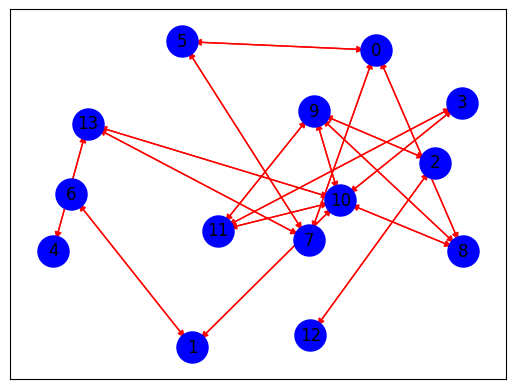

In [ ]:
G_preprocessing = nx.DiGraph()
for i in range(len(cossim_prep)):
    G_preprocessing.add_node(i)

for i in range(len(cossim_prep)):
    for j in range(len(cossim_prep)):
        similarity_preprocessing = cossim_prep[i][j]
        if similarity_preprocessing > 0.1 and i != j:
            G_preprocessing.add_edge(i, j)

pos = nx.spring_layout(G_preprocessing, k=2)
nx.draw_networkx_nodes(G_preprocessing, pos, node_size=500, node_color='b')
nx.draw_networkx_edges(G_preprocessing, pos, edge_color='red', arrows=True)
nx.draw_networkx_labels(G_preprocessing, pos)

plt.show()

#Perhitungan dan Tampilkan Closeness Centrality dari Node Graf
menghitung dan menampilkan nilai closeness centrality untuk setiap node dalam graf berarah.

In [ ]:
closeness_preprocessing = nx.closeness_centrality(G_preprocessing)

sorted_closeness_preprocessing = sorted(closeness_preprocessing.items(), key=lambda x: x[1], reverse=True)
print("Closeness Centrality:")
for node, closeness in sorted_closeness_preprocessing:
    print(f"Node {node}: {closeness:.4f}")

Closeness Centrality:
Node 10: 0.5909
Node 8: 0.5000
Node 9: 0.5000
Node 13: 0.4815
Node 11: 0.4333
Node 0: 0.4062
Node 1: 0.4062
Node 3: 0.3939
Node 7: 0.3824
Node 2: 0.3611
Node 4: 0.3333
Node 5: 0.3171
Node 6: 0.2955
Node 12: 0.2708


#Ringkasan Tiga Node Tertinggi Closeness Centrality dan Kalimat Terkait
mengekstrak dan menampilkan informasi mengenai tiga node dengan nilai closeness centrality tertinggi, termasuk kalimat yang terkait dengan node-node tersebut.

In [ ]:
ringkasan_closeness_preprocessing = ""
print("Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:")
for node, closeness_preprocessing in sorted_closeness_preprocessing[:3]:
    top_sentence = kalimat[node]
    ringkasan_closeness_preprocessing += top_sentence + " "
    print(f"Node {node}: Closeness Centrality = {closeness_preprocessing:.4f}")
    print(f"Kalimat: {top_sentence}\n")

Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:
Node 10: Closeness Centrality = 0.5909
Kalimat: Bung Kesit mengatakan bahwa Rizky Ridho pemain yang selalu diutamakan STY.

Node 8: Closeness Centrality = 0.5000
Kalimat: Ia menyayangkan seharusnya Rizky Ridho dimainakan di awal permainan saat melawan Tiongkok.

Node 9: Closeness Centrality = 0.5000
Kalimat: "Okelah Sandy Walsh tidak bisa dimainkan, Jordi Ahmad tidak bisa dimainkan karena mengalami cedera, tapi di belakang masih ada Rizky Ridho yang sebenarnya selama ini selalu menjadi starter, kecuali dalam pertandingan sebelumnya memang dia duduk dari bangku cadangan," ungkapnya.

